In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

In [2]:
tf.__version__

'1.5.0'

# MNIST MODEL

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def graph(norm):
    tf.reset_default_graph()
    x = tf.placeholder(tf.float32, [None, 784])
    delta = 1. / math.sqrt(100)
    delta2 = 1. / math.sqrt(10)
    
    with tf.device('/gpu:0'):
        if norm=='ln':
            with tf.variable_scope("dense_0"):

                dl_1 = tf.layers.dense(tf.contrib.layers.layer_norm(x),100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("dense_1"):
                dl_2 = tf.layers.dense(tf.contrib.layers.layer_norm(dl_1), 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("dense_2"):
                dl_3 = tf.layers.dense(tf.contrib.layers.layer_norm(dl_2), 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("output"):
                y = tf.nn.softmax(tf.layers.dense( tf.contrib.layers.layer_norm(dl_3), 10, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta2, delta2),
                                      bias_initializer=tf.random_uniform_initializer(-delta2, delta2)))

        if norm=='bn':
            with tf.variable_scope("dense_0"):
                dl_1 = tf.layers.dense(tf.layers.batch_normalization(x), 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("dense_1"):
                dl_2 = tf.layers.dense(tf.layers.batch_normalization(dl_1), 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("dense_2"):
                dl_3 = tf.layers.dense(tf.layers.batch_normalization(dl_2), 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("output"):
                y = tf.nn.softmax(tf.layers.dense(tf.layers.batch_normalization(dl_3), 10, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta2, delta2),
                                      bias_initializer=tf.random_uniform_initializer(-delta2, delta2)))

        if norm == 'none':
            with tf.variable_scope("dense_0"):
                dl_1 = tf.layers.dense(x, 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("dense_1"):
                dl_2 = tf.layers.dense(dl_1, 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("dense_2"):
                dl_3 = tf.layers.dense(dl_2, 100, activation=tf.nn.relu, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta))
            with tf.variable_scope("output"):
                y = tf.nn.softmax(tf.layers.dense(dl_3,10, 
                                      kernel_initializer=tf.random_uniform_initializer(-delta, delta),
                                      bias_initializer=tf.random_uniform_initializer(-delta, delta) )) 

        labels = tf.placeholder(tf.float32, [None, 10])
        cross_entropy = -tf.reduce_mean(tf.reduce_sum(labels * tf.log(y), reduction_indices=[1])) #+\
                                      #tf.reduce_sum((1-labels) * tf.log(1-y), reduction_indices=[1]))
        train_step = tf.train.AdamOptimizer().minimize(cross_entropy)

        correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(labels,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        print(np.sum([np.prod(v.shape) for v in tf.trainable_variables()]))
    return x, y, labels, train_step, accuracy

In [4]:
def training():
    init_op = tf.global_variables_initializer()
    #sess = tf.Session()
    sess = tf.Session( config = tf.ConfigProto(allow_soft_placement = True, log_device_placement = True) )
    sess.run(init_op)
    
    #training_writer = tf.summary.FileWriter('/server/code/ad-hoc/layer-normalisation/tensorboard/mnist_v4')
    #training_writer.add_graph(sess.graph)

    
    acc_values = []
    real_predicted_values = []
    time_stamps = []
    last_time=0
    for i in tqdm(range(1000)):
        batch_xs, batch_ys = mnist.train.next_batch(128)
        
        start_timer = time.time()
        sess.run(train_step, feed_dict={x: batch_xs, labels: batch_ys})
        stop_timer = time.time()
        
#         if i % 99 == 0:
            
#             run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
#             run_metadata = tf.RunMetadata()
#             sess.run(train_step, feed_dict={x: batch_xs, labels: batch_ys}, run_metadata=run_metadata, options=run_options)
#             training_writer.add_run_metadata(run_metadata, 'step%d' % i)
        
        acc_values.append(sess.run(accuracy, feed_dict={x: mnist.test.images, labels: mnist.test.labels}))
        
        real_predicted_values.append(sess.run([labels, tf.argmax(y,1)], feed_dict={x: mnist.test.images, labels: mnist.test.labels}))
        
        last_time = last_time + (stop_timer - start_timer)
        time_stamps.append(last_time)
        

    return time_stamps, acc_values#, real_predicted_values

In [9]:
x, y, labels, train_step, accuracy = graph(norm='ln')
time_stamps_ln, acc_values_ln = training()

x, y, labels, train_step, accuracy = graph(norm='none')
time_stamps_simple, acc_values_simple = training()

x, y, labels, train_step, accuracy = graph(norm='bn')
time_stamps_bn, acc_values_bn = training()

  0%|          | 0/1000 [00:00<?, ?it/s]

101878


  0%|          | 2/1000 [00:00<00:57, 17.48it/s]

99710


  0%|          | 0/1000 [00:00<?, ?it/s]

101878


100%|██████████| 1000/1000 [01:45<00:00,  9.49it/s]


In [13]:
accuracies = [0.6, 0.7, 0.8, 0.9]

def get_steps_and_time(acc_values, time_stamps, accuracy_threshold):
    steps = sum(np.array(acc_values) < accuracy_threshold)
    time = time_stamps[steps-1]
    return steps, time

endings = ['simple', 'ln', 'bn']

results_times = {}
results_steps = {}
for acc in accuracies:
    results_times[acc] = {}
    results_steps[acc] = {}
    for end in endings:
        step, time_spent = get_steps_and_time(eval('acc_values_'+end), eval('time_stamps_'+end), acc )
        results_times[acc][end] = time_spent
        results_steps[acc][end] = step

In [14]:
import pandas as pd
pd.DataFrame(results_times).T

,bn,ln,simple
0.6,0.108215,0.126155,0.080780
0.7,0.138418,0.146885,0.092059
0.8,0.183650,0.202904,0.127575
0.9,0.376593,0.505856,0.365901


In [15]:
pd.DataFrame(results_steps).T

,bn,ln,simple
0.6,10,5,20
0.7,18,8,24
0.8,30,17,37
0.9,81,66,118


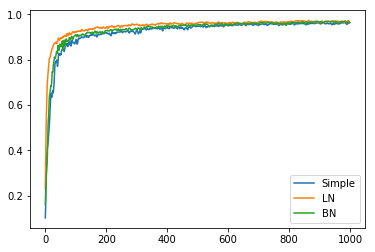

In [12]:
plt.plot(acc_values_simple, label="Simple")
plt.plot(acc_values_ln, label='LN')
plt.plot(acc_values_bn, label='BN')
plt.legend()

(0, 150)

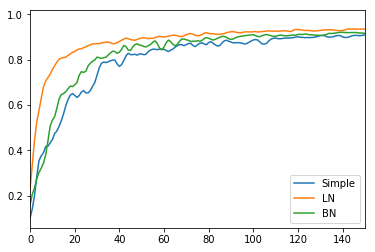

In [13]:
plt.plot(acc_values_simple, label="Simple")
plt.plot(acc_values_ln, label='LN')
plt.plot(acc_values_bn, label='BN')
plt.legend()
plt.xlim([0,150])

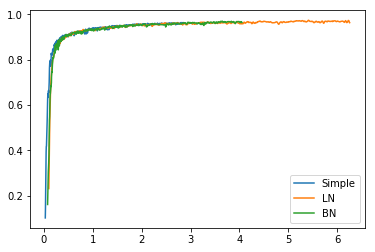

In [14]:
plt.plot(time_stamps_simple, acc_values_simple, label="Simple")
plt.plot(time_stamps_ln, acc_values_ln, label='LN')
plt.plot(time_stamps_bn, acc_values_bn, label='BN')
plt.legend()

(0, 1)

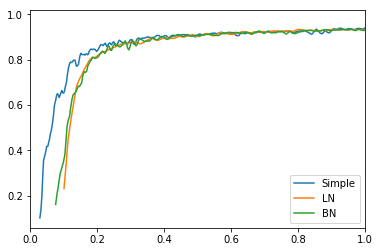

In [15]:
plt.plot(time_stamps_simple, acc_values_simple, label="Simple")
plt.plot(time_stamps_ln, acc_values_ln, label='LN')
plt.plot(time_stamps_bn, acc_values_bn, label='BN')
plt.legend()
plt.xlim([0,1])